In [2]:
import sys
import os

%load_ext autoreload

In [3]:
sys.path.append(os.path.abspath('common/src'))
sys.path.append(os.path.abspath('v1_0_0/src'))
sys.path.append(os.path.abspath('v1_0_1/src'))

In [4]:
import create_rawdf
import scraping
import create_prediction_population
import preprocessing
import prediction
from feature_engineering_prediction import PredictionFeatureCreator
from feature_engineering import FeatureCreator
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
import re
import pandas as pd
import lightgbm as lgb
import graphviz
import matplotlib.pyplot as plt

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%autoreload

In [ ]:
kaisai_date_list = scraping.scrape_kaisai_date(from_="2022-01",to_="2022-12")

  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
race_id_list = scraping.scrape_race_id_list(kaisai_date_list)

  0%|          | 0/108 [00:00<?, ?it/s]

In [23]:
#listをpickleに保存
with open("race_id_list.pickle","wb") as f:
    pickle.dump(race_id_list,f)

In [ ]:
#listをpickleから取得
with open("kaisai_date_list.pickle","rb") as f:
    kaisai_date_list = pickle.load(f)

In [85]:
%autoreload

In [ ]:
html_paths_race = scraping.scrape_html_race(race_id_list = race_id_list)

In [ ]:
#html_paths_raceが消えた時用
html_paths_race = list(scraping.HTML_RACE_DIR.glob("*.bin"))
len(html_paths_race)

3456

In [80]:
results = create_rawdf.create_results(html_path_list=html_paths_race)

  0%|          | 0/3456 [00:00<?, ?it/s]

In [ ]:
INPUT_DIR = Path("data","rawdf")
results = pd.read_csv(INPUT_DIR / "results.csv", sep = "\t")
results

In [86]:
horse_id_list = results["horse_id"].unique()
len(horse_id_list)
html_paths_horse = scraping.scrape_html_horse(horse_id_list= horse_id_list,skip=True)

  0%|          | 0/26077 [00:00<?, ?it/s]

skipped: 2022105230
skipped: 2022101447
skipped: 2022105449
skipped: 2022106209
skipped: 2022100144
skipped: 2022106374
skipped: 2022103177
skipped: 2022100208
skipped: 2022104464
skipped: 2022104995
skipped: 2022102113
skipped: 2022104129
skipped: 2022101826
skipped: 2022105202
skipped: 2021102259
skipped: 2020103339
skipped: 2019101399
skipped: 2021102091
skipped: 2018103388
skipped: 2019104100
skipped: 2021110123
skipped: 2020103673
skipped: 2017109029
skipped: 2021101443
skipped: 2020105470
skipped: 2018100442
skipped: 2017103656
skipped: 2016102446
skipped: 2019103965
skipped: 2021110135
skipped: 2019100794
skipped: 2020102932
skipped: 2019106851
skipped: 2020105201
skipped: 2017105588
skipped: 2018105296
skipped: 2018103503
skipped: 2021110146
skipped: 2020103496
skipped: 2021103301
skipped: 2021107206
skipped: 2020101212
skipped: 2019102793
skipped: 2018105328
skipped: 2018104994
skipped: 2020101429
skipped: 2016104238
skipped: 2020103875
skipped: 2017104415
skipped: 2018100821


HTTPError: HTTP Error 400: Bad Request

In [12]:
#馬の過去成績テーブル作成
horse_results = create_rawdf.create_horse_results(html_path_list=html_paths_horse)

  0%|          | 0/16494 [00:00<?, ?it/s]

In [13]:
race_info = create_rawdf.create_race_info(html_paths_race)

  0%|          | 0/6910 [00:00<?, ?it/s]

'NoneType' object has no attribute 'find' at 202405050701
'NoneType' object has no attribute 'find' at 202405050702
'NoneType' object has no attribute 'find' at 202405050703
'NoneType' object has no attribute 'find' at 202405050704
'NoneType' object has no attribute 'find' at 202405050705
'NoneType' object has no attribute 'find' at 202405050706
'NoneType' object has no attribute 'find' at 202405050707
'NoneType' object has no attribute 'find' at 202405050708
'NoneType' object has no attribute 'find' at 202405050709
'NoneType' object has no attribute 'find' at 202405050710
'NoneType' object has no attribute 'find' at 202405050711
'NoneType' object has no attribute 'find' at 202405050712
'NoneType' object has no attribute 'find' at 202405050801
'NoneType' object has no attribute 'find' at 202405050802
'NoneType' object has no attribute 'find' at 202405050803
'NoneType' object has no attribute 'find' at 202405050804
'NoneType' object has no attribute 'find' at 202405050805
'NoneType' obj

In [14]:
#レース結果テーブルの前処理
results_preprocessed = preprocessing.process_results()

In [15]:
#馬の過去成績テーブルの加工
horse_results_preprocessed = preprocessing.process_horse_results()

In [18]:
#レース情報テーブルの加工
race_info_preprocessed = preprocessing.process_race_info()

## モデル生成

In [8]:
fc = FeatureCreator()
features = fc.create_features()

In [6]:
INPUT_DIR = Path("data","02_features")
features = pd.read_csv(INPUT_DIR / "features.csv", sep = "\t")

In [10]:
feature_cols = [
    'horse_id', 
    'jockey_id', 
    'trainer_id', 
    'sex',
    'age', 
    'weight', 
    'weight_diff', 
    # 'tansho_odds', 
    # 'popularity', 
    'impost',
    'wakuban', 
    'umaban', 
    'race_type', 
    'around', 
    'course_len', 
    'weather',
    'ground_state', 
    'race_class',
    'place',
    # 'rank_1race',
    # 'prize_1race',
    'rank_3races',
    'prize_3races',
    'rank_5races',
    'prize_5races',
    'rank_10races',
    'prize_10races',
    'rank_1000races',
    'prize_1000races'
]

In [13]:
#説明変数
X = features[feature_cols]

#目的変数
y = (features["rank"] == 1).astype(int)
features["target"] = (features["rank"] == 1).astype(int)

In [14]:
# 学習データと検証データにわける。（わけなくたっていい）
train_df = features.query("date < '2024-11-31' and date > '2024-01-01'")
test_df = features.query("date > '2024-11-31'")

In [15]:
len(train_df), len(test_df)

(42328, 3572)

In [17]:
#データセットの作成
lgb_train = lgb.Dataset(
    train_df[feature_cols], train_df["target"]
)

lgb_test = lgb.Dataset(
    test_df[feature_cols], test_df["target"]
)

#パラメータの設定
params = {
    "objective": "binary", # 二値分類
    "metric": "binary_logloss", # 予測誤差
    "random_state":100 # 実行ごとに同じ結果を得るための設定
}

#学習の実行
model = lgb.train(
    params = params,
    train_set = lgb_train,
    valid_sets = [lgb_train, lgb_test],
    callbacks = [lgb.log_evaluation()]
)

[LightGBM] [Info] Number of positive: 3145, number of negative: 39183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 42328, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074301 -> initscore=-2.522429
[LightGBM] [Info] Start training from score -2.522429
[1]	training's binary_logloss: 0.258418	valid_1's binary_logloss: 0.245306
[2]	training's binary_logloss: 0.253858	valid_1's binary_logloss: 0.24182
[3]	training's binary_logloss: 0.250271	valid_1's binary_logloss: 0.239182
[4]	training's binary_logloss: 0.247272	valid_1's binary_logloss: 0.237009
[5]	training's binary_logloss: 0.244594	valid_1's binary_logloss: 0.235439
[6]	training's binary_logloss: 0.242419	valid_1's binary_logloss: 0.2

In [18]:
model.save_model(Path("model","modelbetween0101-1131.txt"))

## オフライン評価
的中率・回収率を見てみる

In [20]:
#テストデータに対して予測をしてみる
model.predict(test_df[feature_cols])

array([0.00910565, 0.00856672, 0.00516645, ..., 0.00481767, 0.17471015,
       0.07528012])

In [22]:
evaluation_df =test_df[
    [
        "race_id",
        "horse_id",
        "target",
        "rank",
        "tansho_odds",
        "popularity"
    ]
].copy()
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity
71589,202406050201,2022100533,0,12,238.7,13
71590,202406050201,2022101365,0,8,191.3,12
71591,202406050201,2022107140,0,15,378.5,15
71592,202406050201,2022100987,0,5,38.7,7
71593,202406050201,2022106335,0,11,126.7,9
...,...,...,...,...,...,...
86806,202408070912,2021100130,1,1,1.9,1
86807,202408070912,2020110133,0,11,43.1,10
86808,202408070912,2019102786,0,3,105.4,14
86809,202408070912,2021102888,0,7,10.6,5


In [24]:
evaluation_df["pred"] = model.predict(test_df[feature_cols])
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
71589,202406050201,2022100533,0,12,238.7,13,0.009106
71590,202406050201,2022101365,0,8,191.3,12,0.008567
71591,202406050201,2022107140,0,15,378.5,15,0.005166
71592,202406050201,2022100987,0,5,38.7,7,0.020252
71593,202406050201,2022106335,0,11,126.7,9,0.024554
...,...,...,...,...,...,...,...
86806,202408070912,2021100130,1,1,1.9,1,0.373121
86807,202408070912,2020110133,0,11,43.1,10,0.027932
86808,202408070912,2019102786,0,3,105.4,14,0.004818
86809,202408070912,2021102888,0,7,10.6,5,0.174710


In [28]:
bet_df = (
    evaluation_df
    .sort_values("pred",ascending=False)
    .groupby("race_id")
    .head(1)
    # .tail(1)
)

#的中率
bet_df["target"].mean()

np.float64(0.21224489795918366)

In [27]:
#返ってくる金額
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
return_

np.float64(149.1)

In [30]:
#賭けた金額
cost = len(bet_df)
cost

return_ / cost

np.float64(0.6085714285714285)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

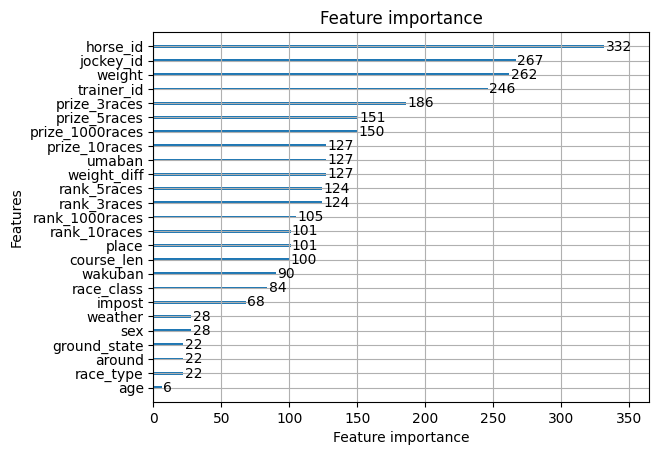

In [31]:
lgb.plot_importance(model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

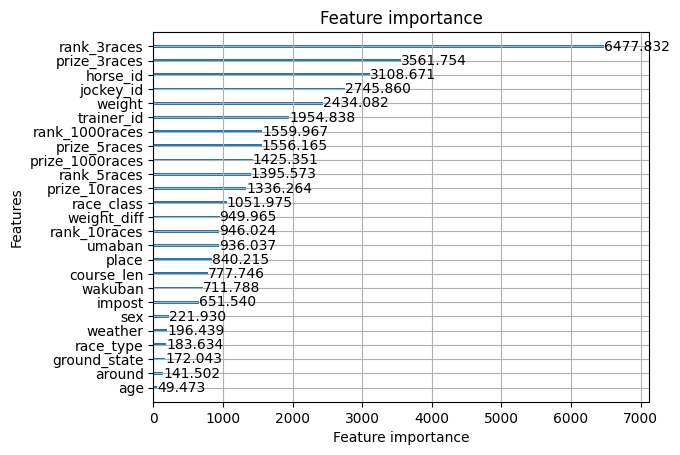

In [32]:
lgb.plot_importance(model,importance_type="gain")

## レース前日準備
### 予測母集団の作成
予測したい日の（日付,race_id,horse_id）のペアを作る

In [57]:
prediction_population = create_prediction_population.create("20250106")

scraping race_id_list...


  0%|          | 0/1 [00:00<?, ?it/s]

['202506010201', '202506010202', '202506010203', '202506010204', '202506010205', '202506010206', '202506010207', '202506010208', '202506010209', '202506010210', '202506010211', '202506010212', '202507010201', '202507010202', '202507010203', '202507010204', '202507010205', '202507010206', '202507010207', '202507010208', '202507010209', '202507010210', '202507010211', '202507010212']
scraping horse_id_list...


  0%|          | 0/24 [00:00<?, ?it/s]

## 馬の過去成績の取得

In [58]:
html_paths_horse = scraping.scrape_html_horse(
    horse_id_list = prediction_population["horse_id"].unique(),
    skip = False
)

  0%|          | 0/382 [00:00<?, ?it/s]

In [59]:
horse_results_prediction = create_rawdf.create_horse_results(
    html_path_list = html_paths_horse,
    save_filename = "horse_results_prediction.csv"
)

  0%|          | 0/382 [00:00<?, ?it/s]

table not found at 2022105531
table not found at 2022106473
table not found at 2022102136
table not found at 2022104499
table not found at 2022109083
table not found at 2022101621
table not found at 2022103990
table not found at 2022102996
table not found at 2022101669
table not found at 2022110130
table not found at 2022102978
table not found at 2022101196
table not found at 2022106656
table not found at 2022110158
table not found at 2022100029
table not found at 2022110119
table not found at 2022106114
table not found at 2022107261
table not found at 2022102823
table not found at 2022100298
table not found at 2022106558
table not found at 2022106707
table not found at 2022101242
table not found at 2022104779
table not found at 2022104890
table not found at 2022100087
table not found at 2022105608
table not found at 2022102325
table not found at 2022104199


# 予測時の処理
## レース前日準備

In [60]:
horse_results_preprocessed = preprocessing.process_horse_results(
    save_filename="horse_results_prediction.csv"
)

### レース当日の処理

In [10]:
#特徴量作成
pfc = PredictionFeatureCreator()

#馬の過去成績集計は事前に行っておいてもよい
pfc.create_baselog()
pfc.agg_horse_n_races()

pfc.agg_horse_n_races_df

,date,race_id,horse_id,rank_3races,prize_3races,rank_5races,prize_5races,rank_10races,prize_10races,rank_1000races,prize_1000races
0,2025-01-06,202506010201,2022103758,8.000000,27.666667,8.000000,27.666667,8.000000,27.666667,8.000000,27.666667
1,2025-01-06,202506010201,2022106861,5.333333,46.666667,5.333333,46.666667,5.333333,46.666667,5.333333,46.666667
2,2025-01-06,202506010201,2022103333,13.333333,0.000000,13.333333,0.000000,13.333333,0.000000,13.333333,0.000000
3,2025-01-06,202506010201,2022106669,3.000000,180.000000,3.000000,180.000000,3.000000,180.000000,3.000000,180.000000
4,2025-01-06,202506010201,2022106454,10.500000,27.500000,10.500000,27.500000,10.500000,27.500000,10.500000,27.500000
...,...,...,...,...,...,...,...,...,...,...,...
345,2025-01-06,202507010212,2020104160,9.333333,0.000000,11.400000,0.000000,7.100000,195.200000,6.533333,172.333333
346,2025-01-06,202507010212,2021105746,4.666667,293.333333,4.400000,263.840000,3.700000,285.920000,3.700000,285.920000
347,2025-01-06,202507010212,2019105154,2.333333,494.600000,3.800000,360.760000,4.200000,267.380000,3.750000,298.650000
348,2025-01-06,202507010212,2021101412,3.333333,373.333333,2.800000,374.000000,3.900000,231.000000,4.545455,210.000000


In [95]:
%autoreload

In [13]:
features = pfc.create_features(
    race_id="202506010201",
    skip_agg_horse = True) #事前に集計した場合はスキップできる

fetching shubuta page html...


c:\Users\hisaf\KeibaAI-main\KeibaAI-training\v1_0_0\src\feature_engineering_prediction.py:173: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(html)[0]


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

merging all features...


In [14]:
prediction.predict(features,output_filename="predict_result_20250106_3歳未勝利.csv")

,race_id,umaban,tansho_odds,popularity,pred
12,202506010201,13,2.6,1,0.333479
14,202506010201,15,6.2,4,0.146273
3,202506010201,4,4.7,3,0.110183
10,202506010201,11,84.2,9,0.040988
1,202506010201,2,10.7,5,0.036894
15,202506010201,16,18.2,7,0.035966
0,202506010201,1,4.4,2,0.035750
13,202506010201,14,34.7,8,0.031195
8,202506010201,9,213.5,11,0.020727
5,202506010201,6,227.9,12,0.020431
